# Spatial accessibility modelling based on travel times

One of the handy Python libraries that can be used to calculate travel time matrices needed for spatial accessibility modelling is `r5py`. This library can be used for routing and calculating travel time matrices on multimodal transport networks (walk, bike, public transport and car). It provides a simple and friendly interface to R<sup>5</sup> (*the Rapid Realistic Routing on Real-world and Reimagined networks*) which is a [routing engine](https://github.com/conveyal/r5) developed by [Conveyal](https://conveyal.com/). `R5py` is designed to interact with [GeoPandas](https://geopandas.org) GeoDataFrames, and it is inspired by [r5r](https://ipeagit.github.io/r5r) which is a similar wrapper developed for R. `R5py` exposes some of R5’s functionality via its Python API, in a syntax similar to r5r’s. 

## Data requirements

### Data for creating a routable network

When calculating travel times with `r5py`, you typically need a couple of datasets: 

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) -format: 
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit. 
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g. by cropping the data or adding special costs for travelling (e.g. for considering slope when cycling/walking). When doing this, you should follow the instructions at [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) -format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about [GTFS standard from here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5py` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing e.g. the bus and metro connections. 


### Data for origin and destination locations

In addition to OSM and GTFS datasets, you need data that represents the origin and destination locations (OD-data) for routings. This data is typically stored in one of the geospatial data formats, such as Shapefile, GeoJSON or GeoPackage. As `r5py` is build on top of `geopandas`, it is easy to read OD-data from various different data formats. 


### Where to get these datasets?

Here are a few places from where you can download the datasets for creating the routable network:

- **OpenStreetMap data in PBF-format**:


  - [Protomaps](https://protomaps.com/downloads/osm) -website. Allows to download the data with custom extent by specifying your own area of interest.
  - [pyrosm](https://pyrosm.readthedocs.io/en/latest/basics.html#protobuf-file-what-is-it-and-how-to-get-one)  -library. Allows downloading data directly from Python (based on GeoFabrik and BBBike).
  - [pydriosm](https://pydriosm.readthedocs.io/en/latest/quick-start.html#download-data) -library. Allows downloading data directly from Python (based on GeoFabrik and BBBike).
  - [GeoFabrik](http://download.geofabrik.de/) -website. Has data extracts for many pre-defined areas (countries, regions, etc).
  - [BBBike](https://download.bbbike.org/osm/bbbike/) -website. Has data extracts readily available for many cities across the world. Also supports downloading data by [specifying your own area or interest](https://extract.bbbike.org/).


- **GTFS data**:  
  - [Transitfeeds](https://transitfeeds.com/) -website. Easy to navigate and find GTFS data for different countries and cities. Includes current and historical GTFS data. Notice: The site will be depracated in the future.  
  - [Mobility Database](https://mobilitydatabase.org) -website. Will eventually replace TransitFeeds -website. 
  - [Transitland](https://www.transit.land/operators) -website. Find data based on country, operator or feed name. Includes current and historical GTFS data.

### Sample datasets

In the following tutorial, we use various open source datasets:
- The point dataset for Helsinki has been obtained from [Helsinki Region Environmental Services](https://www.hsy.fi/en/environmental-information/open-data/avoin-data---sivut/population-grid-of-helsinki-metropolitan-area/) (HSY) licensed under a Creative Commons By Attribution 4.0. 
- The street network for Helsinki is a cropped and filtered extract of OpenStreetMap (© OpenStreetMap contributors, [ODbL license](https://www.openstreetmap.org/copyright))
- The GTFS transport schedule dataset for Helsinki is a cropped and minimised copy of Helsingin seudun liikenne’s (HSL) open dataset [Creative Commons BY 4.0](https://www.hsl.fi/hsl/avoin-data#aineistojen-kayttoehdot).

## Getting started with `r5py`

In this tutorial, we will learn how to calculate travel times with `r5py` between locations spread around the city center area of Helsinki, Finland. 

### Load and prepare the origin and destination data

Let's start by downloading a sample dataset into a geopandas `GeoDataFrame` that we can use as our destination locations. To make testing the library easier, we have prepared a helper `r5py.sampledata.helsinki` which can be used to easily download the sample data sets for Helsinki (including population grid, GTFS data and OSM data). The population grid data covers the city center area of Helsinki and contains information about residents of each 250 meter cell:

In [1]:
import geopandas as gpd
import osmnx as ox
import r5py.sampledata.helsinki

pop_grid_fp = r5py.sampledata.helsinki.population_grid
pop_grid = gpd.read_file(pop_grid_fp)
pop_grid.head()

id  population                                           geometry
0   0         389  POLYGON ((24.90545 60.16086, 24.90545 60.16311...
1   1         296  POLYGON ((24.90546 60.15862, 24.90545 60.16086...
2   2         636  POLYGON ((24.90547 60.15638, 24.90546 60.15862...
3   3        1476  POLYGON ((24.90547 60.15413, 24.90547 60.15638...
4   4          23  POLYGON ((24.90994 60.16535, 24.90994 60.1676,...

The `pop_grid` GeoDataFrame contains a few columns, namely `id`, `population` and `geometry`. The `id` column with unique values and `geometry` columns are required for `r5py` to work. If your input dataset does not have an `id` column with unique values, `r5py` will throw an error. 

To get a better sense of the data, let's create a map that shows the locations of the polygons and visualise the number of people living in each cell:

In [2]:
pop_grid.explore("population", cmap="Reds")

#### Convert polygon layer to points

Lastly, we need to convert the Polygons into points because **r5py expects that the input data is represented as points**. We can do this by making a copy of our grid and calculating the centroid of the Polygons. 

*Note: You can ignore the UserWarning raised by geopandas about the geographic CRS. The location of the centroid is accurate enough for most purposes.*

In [3]:
# Convert polygons into points
points = pop_grid.copy()
points["geometry"] = points.centroid
points.explore(max_zoom=13, color="red")

/var/folders/f7/rhmqxfmx40s4yv9bhh7skq4m0000gp/T/ipykernel_3166/415363510.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points["geometry"] = points.centroid


#### Retrieve the origin location by geocoding an address

Let's geocode an address for Helsinki Railway Station into a GeoDataFrame using `osmnx` and use that as our **origin** location:

In [5]:
from shapely.geometry import Point 

address = "Central Railway station, Helsinki, Finland"
lat, lon = ox.geocode(address)

# Create a GeoDataFrame out of the coordinates
origin = gpd.GeoDataFrame({"geometry": [Point(lon, lat)], "name": "Helsinki Railway station", "id": [0]}, index=[0], crs="epsg:4326")
origin.explore(max_zoom=13, color="red", marker_kwds={"radius": 12})

### Load transport network

Virtually all operations of `r5py` require a transport network. In this example, we use data from Helsinki metropolitan area, which you can easily obtain from the `r5py.sampledata.helsinki` library. The files will be downloaded automatically to a temporary folder on your computer when you call the variables `*.osm_pbf` and `*.gtfs`:

In [6]:
# Download OSM data
r5py.sampledata.helsinki.osm_pbf

SampleDataSet('/Users/tenkanh2/.cache/r5py/sampledata/kantakaupunki.osm.pbf')

In [7]:
# Download GTFS data
r5py.sampledata.helsinki.gtfs

SampleDataSet('/Users/tenkanh2/.cache/r5py/sampledata/helsinki_gtfs.zip')

To import the street and public transport networks, instantiate an `r5py.TransportNetwork` with the file paths to the OSM extract and the GTFS files:

In [8]:
from r5py import TransportNetwork

# Get the filepaths to sample data (OSM and GTFS)
helsinki_osm = r5py.sampledata.helsinki.osm_pbf
helsinki_gtfs = r5py.sampledata.helsinki.gtfs

transport_network = TransportNetwork(
    # OSM data
    helsinki_osm,
    
    # A list of GTFS file(s)
    [
        helsinki_gtfs,
    ]
)

In [7]:
transport_network

In [9]:
# You can explore various attributes of the transit layer such as routes
transport_network.transit_layer.routes[0].agency_id

'HSL'

At this stage, `r5py` has created the routable transport network and it is stored in the `transport_network` variable. We can now start using this network for doing the travel time calculations. 

### Compute travel time matrix from one to all locations

A travel time matrix is a dataset detailing the travel costs (e.g., time) between given locations (origins and destinations) in a study area. To compute a travel time matrix with `r5py` based on public transportation, we initialize an `r5py.TravelTimeMatrix` -object. As inputs, we pass following arguments for the `TravelTimeMatrix`:
- `transport_network`, which we created in the previous step representing the routable transport network. 
- `origins`, which is a GeoDataFrame with one location that we created earlier (however, you can also use multiple locations as origins).
- `destinations`, which is a GeoDataFrame representing the destinations (in our case, the `points` GeoDataFrame). 
- `departure`, which should be Python's `datetime` -object (in our case standing for "22nd of February 2022 at 08:30") to tell `r5py` that the schedules of this specific time and day should be used for doing the calculations. 
   - *Note*: By default, `r5py` summarizes and calculates a median travel time from all possible connections within 10 minutes from given depature time (with 1 minute frequency). It is possible to adjust this time window using `departure_time_window` -parameter ([see details here]((https://r5py.readthedocs.io/en/latest/reference/reference.html#r5py.RegionalTask))). For robust spatial accessibility assessment (e.g. in scientific works), we recommend to use 60 minutes `departure_time_window`. 
- `transport_modes`, which determines the travel modes that will be used in the calculations. These can be passed using the options from the `r5py.TransportMode` -class. 
  - *Hint*: To see all available options, run `help(r5py.TransportMode)`.  

```{note}
In addition to these ones, the constructor also accepts many other parameters [listed here](https://r5py.readthedocs.io/en/latest/reference/reference.html#r5py.RegionalTask), such as walking and cycling speed, maximum trip duration, maximum number of transit connections used during the trip, etc. 
```
Now, we will create a `travel_time_matrix` instance as described above which will compute as the travel times between the given origins and destinations:

In [10]:
import datetime
from r5py import TravelTimeMatrix, TransportMode

# Initialize the tool
travel_time_matrix = TravelTimeMatrix(
    transport_network,
    origins=origin,
    destinations=points,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK]
)

In [12]:
# To see all available transport modes, uncomment following
# help(TransportMode)

In [13]:
travel_time_matrix.head()

from_id  to_id  travel_time
0        0      0           14
1        0      1           16
2        0      2           18
3        0      3           22
4        0      4           17

As a result, this returns a `pandas.DataFrame` which we stored in the `travel_time_matrix` -variable. The values in the `travel_time` column are travel times in minutes between the points identified by `from_id` and `to_id`. As you can see, the `id` value in the `from_id` column is the same for all rows because we only used one origin location as input. 

To get a better sense of the results, let's create a travel time map based on our results. We can do this easily by making a table join between the `pop_grid` GeoDataFrame and the `travel_time_matrix`. The key in the `travel_time_matrix` table is the column `to_id` and the corresponding key in `pop_grid` GeoDataFrame is the column `id`. Notice that here we do the table join with the original the Polygons layer (for visualization purposes). However, the join could also be done in a similar manner with the `points` GeoDataFrame.

In [14]:
join = pop_grid.merge(travel_time_matrix, left_on="id", right_on="to_id")
join.head()

id  population                                           geometry  from_id  \
0   0         389  POLYGON ((24.90545 60.16086, 24.90545 60.16311...        0   
1   1         296  POLYGON ((24.90546 60.15862, 24.90545 60.16086...        0   
2   2         636  POLYGON ((24.90547 60.15638, 24.90546 60.15862...        0   
3   3        1476  POLYGON ((24.90547 60.15413, 24.90547 60.15638...        0   
4   4          23  POLYGON ((24.90994 60.16535, 24.90994 60.1676,...        0   

   to_id  travel_time  
0      0           14  
1      1           16  
2      2           18  
3      3           22  
4      4           17

Now we have the travel times attached to each point, and we can easily visualize them on a map:

In [15]:
m = join.explore("travel_time", cmap="Greens", max_zoom=13)
m = origin.explore(m=m, color="red", marker_kwds={"radius": 10})
m

### Compute travel time matrix from all to all locations

Running the calculations between all points in our sample dataset can be done in a similar manner as calculating the travel times from one origin to all destinations. 
Since, calculating these kind of all-to-all travel time matrices is quite typical when doing accessibility analyses, it is actually possible to calculate a cross-product between all points just by using the `origins` parameter (i.e. without needing to specify a separate set for destinations). `r5py` will use the same points as destinations and produce a full set of origins and destinations:


In [16]:
travel_time_matrix_all = TravelTimeMatrix(
    transport_network,
    origins=points,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK]
)
travel_time_matrix_all.head()

from_id  to_id  travel_time
0        0      0            0
1        0      1            7
2        0      2           10
3        0      3           18
4        0      4           13

In [17]:
travel_time_matrix_all.tail()

from_id  to_id  travel_time
8459       91     87           27
8460       91     88           23
8461       91     89           10
8462       91     90            6
8463       91     91            0

In [18]:
len(travel_time_matrix_all)

8464

As we can see from the outputs above, now we have calculated travel times between all points (n=92) in the study area. Hence, the resulting DataFrame has almost 8500 rows (92x92=8464). Based on these results, we can for example calculate the median travel time to or from a certain point, which gives a good estimate of the overall accessibility of the location in relation to other points:

In [19]:
median_times = travel_time_matrix_all.groupby("from_id")["travel_time"].median()
median_times

from_id
0     22.0
1     25.0
2     27.0
3     28.0
4     26.0
      ... 
87    25.0
88    25.0
89    23.0
90    26.0
91    28.0
Name: travel_time, Length: 92, dtype: float64

To estimate, how long does it take in general to travel between locations in our study area (i.e. what is the baseline accessibility in the area), we can calculate the mean (or median) of the median travel times showing that it is approximately 22 minutes:

In [20]:
median_times.mean()

np.float64(21.918478260869566)

Naturally, we can also visualize these values on a map:

In [21]:
overall_access = pop_grid.merge(median_times.reset_index(), left_on="id", right_on="from_id")
overall_access.head()

id  population                                           geometry  from_id  \
0   0         389  POLYGON ((24.90545 60.16086, 24.90545 60.16311...        0   
1   1         296  POLYGON ((24.90546 60.15862, 24.90545 60.16086...        1   
2   2         636  POLYGON ((24.90547 60.15638, 24.90546 60.15862...        2   
3   3        1476  POLYGON ((24.90547 60.15413, 24.90547 60.15638...        3   
4   4          23  POLYGON ((24.90994 60.16535, 24.90994 60.1676,...        4   

   travel_time  
0         22.0  
1         25.0  
2         27.0  
3         28.0  
4         26.0

In [22]:
overall_access.explore("travel_time", cmap="Blues", scheme="natural_breaks", k=4)

In out study area, there seems to be a bit poorer accessibility in the Southern areas and on the edges of the region (i.e. we wittness a classic edge-effect here). 

## Advanced usage

### Compute travel times with a detailed information about the routing results

In case you are interested in more detailed routing results, it is possible to use `DetailedItineraries` class. This will provide not only the same information as in the previous examples, but it also brings much more detailed information about the routings. When using this functionality, `r5py` produces information about the used routes for each origin-destination pair (with possibly multiple alternative routes), as well as individual trip segments and information about the used modes, public transport route-id information (e.g. bus-line number), distanes, waiting times and the actual geometry used. 

```{important}

Computing detailed itineraries is significantly more time-consuming than calculating simple travel times. As such, think twice whether you actually need the detailed information output from this function, and how you might be able to limit the number of origins and destinations you need to compute.

```

In [23]:
from r5py import DetailedItineraries

# Take a small sample of destinations for demo purposes
points_sample = points.sample(10)

travel_details = DetailedItineraries(
    transport_network,
    origins=origin,
    destinations=points_sample,
    departure=datetime.datetime(2022,2,22,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
    
    # With following attempts to snap all origin and destination points to the transport network before routing
    snap_to_network=True,
)
travel_details.head(10)

from_id  to_id  option  segment        transport_mode      departure_time  \
0        0      3       0        0    TransportMode.WALK                 NaT   
1        0      3       1        0    TransportMode.WALK 2022-02-22 08:32:12   
2        0      3       1        1  TransportMode.SUBWAY 2022-02-22 08:41:00   
3        0      3       1        2    TransportMode.WALK 2022-02-22 08:45:00   
4        0      3       2        0    TransportMode.WALK 2022-02-22 08:32:12   
5        0      3       2        1  TransportMode.SUBWAY 2022-02-22 08:38:00   
6        0      3       2        2    TransportMode.WALK 2022-02-22 08:45:00   
7        0      3       3        0    TransportMode.WALK 2022-02-22 08:32:12   
8        0      3       3        1  TransportMode.SUBWAY 2022-02-22 08:35:00   
9        0      3       3        2    TransportMode.WALK 2022-02-22 08:39:00   

      distance     travel_time       wait_time           feed agency_id  \
0  2749.999000 0 days 00:47:01 0 days 00:00:00           None      None   
1     3.985000 0 days 00:00:04 0 days 00:00:00           None      None   
2  3268.720134 0 days 00:03:00 0 days 00:02:12  helsinki_gtfs       HSL   
3  1255.231000 0 days 00:21:33 0 days 00:00:00           None      None   
4     3.985000 0 days 00:00:04 0 days 00:00:00           None      None   
5  3268.720134 0 days 00:03:00 0 days 00:02:33  helsinki_gtfs       HSL   
6  1255.231000 0 days 00:21:33 0 days 00:00:00           None      None   
7     3.985000 0 days 00:00:04 0 days 00:00:00           None      None   
8  3268.720134 0 days 00:03:00 0 days 00:02:54  helsinki_gtfs       HSL   
9    98.685000 0 days 00:01:39 0 days 00:01:00           None      None   

  route_id start_stop_id end_stop_id  \
0     None          None        None   
1     None          None        None   
2     31M1       1020602     1201602   
3     None          None        None   
4     None          None        None   
5     31M2       1020602     1201602   
6     None          None        None   
7     None          None        None   
8     31M1       1020602     1201602   
9     None          None        None   

                                            geometry  
0  LINESTRING (24.94019 60.17047, 24.93991 60.170...  
1  LINESTRING (24.94019 60.17047, 24.93991 60.170...  
2  LINESTRING (24.93983 60.17053, 24.93954 60.170...  
3  LINESTRING (24.90826 60.15478, 24.90825 60.154...  
4  LINESTRING (24.94019 60.17047, 24.93991 60.170...  
5  LINESTRING (24.93983 60.17053, 24.93954 60.170...  
6  LINESTRING (24.90826 60.15478, 24.90825 60.154...  
7  LINESTRING (24.94019 60.17047, 24.93991 60.170...  
8  LINESTRING (24.93983 60.17053, 24.93954 60.170...  
9  LINESTRING (24.91563 60.16307, 24.9156 60.1632...

As you can see, the result contains much more information than earlier, see the following table for explanations:

| Column             | Description                                                                                             | Data type          |
| ------------------ | --------------------------------------------------------------------------------------------------------| -------------------|
| **from_id**        | the origin of the trip this segment belongs to                                                          | any, user defined  |
| **to_id**          | the destination of the trip this segment belongs to                                                     | any, user defined  |
| **option**         | sequential number for different trip options found                                                      | int                |
| **segment**        | sequential number for segments of the current trip options                                              | int                |
| **transport_mode** | the transport mode used on the current segment                                                          | r5py.TransportMode |
| **departure_time** | the transit departure date and time used for current segment                                            | datetime.datetime  |
| **distance**       | the travel distance in metres for the current segment                                                   | float              |
| **travel_time**    | The travel time for the current segment                                                                 | datetime.timedelta |
| **wait_time**      | The wait time between connections when using public transport                                           | datetime.timedelta |
| **feed**           | The identifier for the GTFS feed used                                                                   | str                |
| **agency_id**      | The identifier for the transit Agency operator                                                          | str                |
| **route_id**       | The route number or id for public transport route used on a segment                                     | str                |
| **start_stop_id**  | The stop id of the first stop on a given trip segment                                                   | int                |
| **end_stop_id**    | The stop id of the last stop on a given trip segment                                                    | int                |
| **geometry**       | The path travelled on a current segment                                                                 | shapely.LineString |


### Visualize the routes on a map

In the following, we will make a nice interactive visualization out of the results, that shows the fastest routes and the mode of transport between the given origin-destination pairs (with multiple alternative trips/routes):

In [24]:
import folium 
import folium.plugins

# Convert travel mode to string (from r5py.TransportMode object)
travel_details["mode"] = travel_details["transport_mode"].astype(str)

# Calculate travel time in minutes (from timedelta)
travel_details["travel time (min)"] = (travel_details["travel_time"].dt.total_seconds() / 60).round(2)

# Generate text for given trip ("origin" to "destination")
travel_details["trip"] = travel_details["from_id"].astype(str) + " to " + travel_details["to_id"].astype(str)

# Choose columns for visualization
selected_cols = ["geometry", "distance", "mode", "route_id", "travel time (min)", "trip", "from_id", "to_id", "option", "segment"  ]

# Generate the map
m = travel_details[selected_cols].explore(
    tooltip=["trip", "option", "segment", "mode", "route_id", "travel time (min)", "distance"],
    column="mode",
    tiles="CartoDB.Positron",
    )

# Add marker for the origin
m = origin.explore(m=m, marker_type="marker", marker_kwds=dict(icon=folium.Icon(color="green", icon="train", prefix="fa", )))

# Add customized markers for destinations
points_sample.apply(lambda row: (
        # Marker with destination ID number attached to the icon
        folium.Marker(
            (row["geometry"].y, row["geometry"].x),
            icon=folium.plugins.BeautifyIcon(
                icon_shape="marker",
                number=row["id"],
                border_color="#728224",
                text_color="#728224",
            )
        # Add the marker to existing map    
        ).add_to(m)), axis=1,
)

m


As a result, now we have a nice map that shows alternative routes between Railway station and the given destinations in the study area. 
If you hover over the lines, you can see details about the selected routes with useful information about the travel time, distance, route id (line number) etc.
Hence, as such, if you're feeling nerdy (and happen to have Python installed to your phone 😛), you could replace your Google Maps navigator or other journey planners with `r5py`! 🤓😉

## Large-scale analyses - Travel time matrices covering massive number of connections

When trying to understand the accessibility of a specific location, you typically want to look at travel times between multiple locations (one-to-many). Next, we will learn how to calculate travel time matrices using `r5py` Python library. 

When calculating travel times with `r5py`, you typically need a couple of datasets:

- **A road network dataset from OpenStreetMap** (OSM) in Protocolbuffer Binary (`.pbf`) format:
  - This data is used for finding the fastest routes and calculating the travel times based on walking, cycling and driving. In addition, this data is used for walking/cycling legs between stops when routing with transit.
  - *Hint*: Sometimes you might need modify the OSM data beforehand, e.g., by cropping the data or adding special costs for travelling (e.g., for considering slope when cycling/walking). When doing this, you should follow the instructions on the [Conveyal website](https://docs.conveyal.com/prepare-inputs#preparing-the-osm-data). For adding customized costs for pedestrian and cycling analyses, see [this repository](https://github.com/RSGInc/ladot_analysis_dataprep).

- **A transit schedule dataset** in General Transit Feed Specification (GTFS.zip) format (optional):
   - This data contains all the necessary information for calculating travel times based on public transport, such as stops, routes, trips and the schedules when the vehicles are passing a specific stop. You can read about the [GTFS standard here](https://developers.google.com/transit/gtfs/reference).
   - *Hint*: `r5py` can also combine multiple GTFS files, as sometimes you might have different GTFS feeds representing, e.g., the bus and metro connections.

## Download the data (optional: download if you work on own computer)

If you have installed the `r5py` and other relevant Python libraries and run the analysis using your own computer, you can download the tutorial data from this link:

- [CLICK and Download the data covering Helsinki Metropolitan Area](https://drive.google.com/file/d/1LxV5z9ho2LGAsHniIOufUKlWx3qUxE0x/view?usp=sharing) (90 MB). The ZIP file contains two files: 

1. Helsinki.osm.pbf - Covers the OSM data for Helsinki Region (cities of Helsinki, Espoo, Vantaa, Kauniainen)
2. GTFS_Helsinki.zip - Covers the GTFS data for Helsinki Region.


### Sample datasets

In the following tutorial, we use open source datasets from Helsinki Region:
- The point dataset for Helsinki has been obtained from [Helsinki Region Environmental Services](https://www.hsy.fi/en/environmental-information/open-data/avoin-data---sivut/population-grid-of-helsinki-metropolitan-area/) (HSY) licensed under a Creative Commons By Attribution 4.0.
- The street network for Helsinki is a cropped and filtered extract of OpenStreetMap (© OpenStreetMap contributors, [ODbL license](https://www.openstreetmap.org/copyright))
- The GTFS transport schedule dataset for Helsinki is an extract of Helsingin seudun liikenne’s (HSL) open dataset ([Creative Commons BY 4.0](https://www.hsl.fi/hsl/avoin-data#aineistojen-kayttoehdot)).
<!-- #endregion -->

### Load the origin and destination data

Let's start by downloading a sample point dataset into a geopandas `GeoDataFrame` that we can use as our origin and destination locations. For the sake of this exercise, we have prepared a grid of points covering parts of Helsinki. The point data also contains the number of residents of each 250 meter cell:

<Axes: >

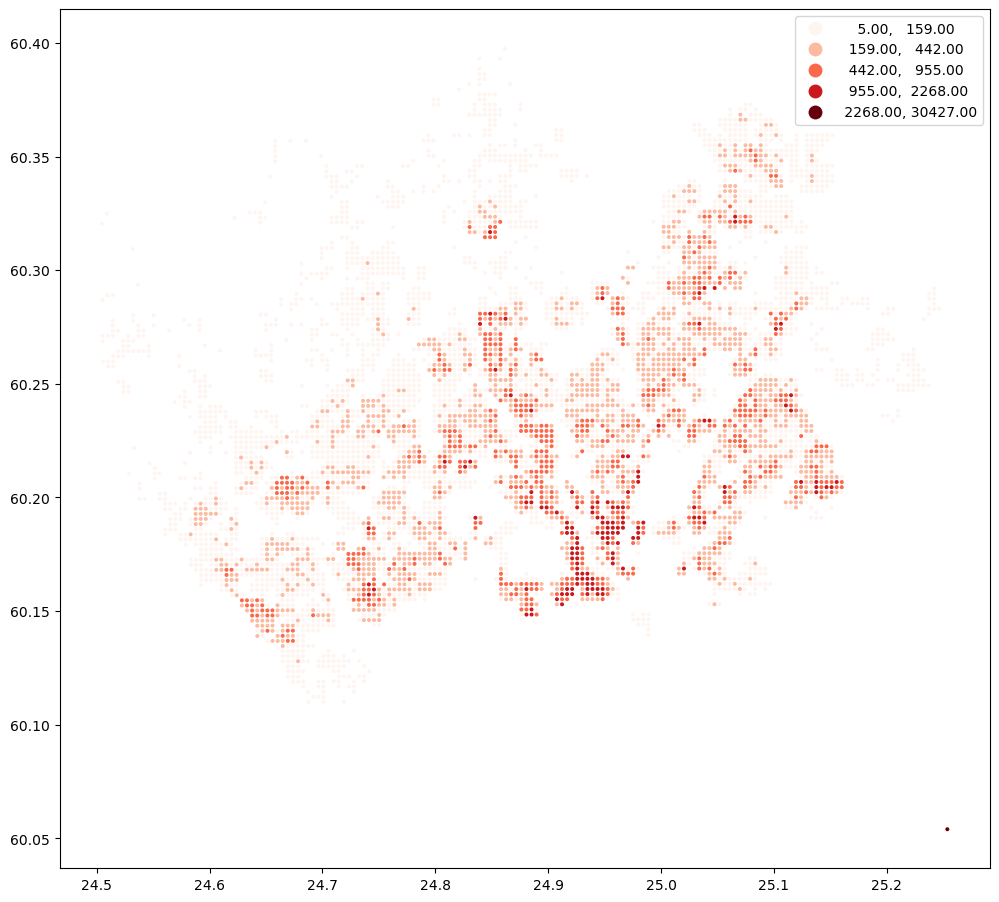

In [25]:
import geopandas as gpd
import ssl

# Without the following you might get certificate error (at least on Linux)
ssl._create_default_https_context = ssl._create_unverified_context

# Calculate travel times to railway station from all grid cells
pop_grid_wfs = "https://kartta.hsy.fi/geoserver/wfs?request=GetFeature&typename=asuminen_ja_maankaytto:Vaestotietoruudukko_2021&outputformat=JSON"
pop_grid = gpd.read_file(pop_grid_wfs)

# Get centroids
points = pop_grid.copy()
points["geometry"] = points.centroid

# Reproject
points = points.to_crs(epsg=4326)
points.plot("asukkaita", scheme="natural_breaks", cmap="Reds", figsize=(12,12), legend=True, markersize=3.5)

Next, we will geocode the address for Helsinki Railway station. For doing this, we can use `oxmnx` library and its handy `.geocode()` -function:

In [26]:
import osmnx as ox
from shapely.geometry import Point

# Find coordinates of the central railway station of Helsinki
lat, lon = ox.geocode("Rautatieasema, Helsinki")

# Create a GeoDataFrame out of the coordinates
station = gpd.GeoDataFrame({"geometry": [Point(lon, lat)], "name": "Helsinki Railway station", "id": [0]}, index=[0], crs="epsg:4326")
station.explore(max_zoom=13, color="red", marker_kwds={"radius": 12})

- Next, we will prepare the routable network in a similar fashion as before, but now we use the larger data files which we downloaded earlier.

In [1]:
# UPDATE MAX MEMORY
# -----------------

# If you run the tutorial on CSC Noppe, run this cell before continuing the tutorial.

# Note: This cell is hidden from the website.
# This cell does not have an effect on local computer.
# It’s used to set a stricter memory limit if the Notebook is running on CSC Noppe or Binder, 
# otherwise, the examples would fail

import sys
import os

if "MEM_LIMIT" in os.environ:  # binder/kubernetes!
    max_memory = int(os.environ["MEM_LIMIT"]) / 2
    sys.argv.extend(["--max-memory", f"{max_memory}"])

In [27]:
import datetime
from r5py import TransportNetwork, TravelTimeMatrix, TransportMode

# Filepath to OSM data
osm_fp = "shared/data/Helsinki/Helsinki.osm.pbf"

transport_network = TransportNetwork(
    osm_fp,
    [
        "shared/data/Helsinki/GTFS_Helsinki.zip"
    ]
)


- After this step, we can do the routing

In [28]:
travel_time_matrix = TravelTimeMatrix(
    transport_network,
    origins=station,
    destinations=points,
    departure=datetime.datetime(2022,8,15,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
)

In [29]:
travel_time_matrix.head()

from_id                       to_id  travel_time
0        0  Vaestotietoruudukko_2021.1         90.0
1        0  Vaestotietoruudukko_2021.2         82.0
2        0  Vaestotietoruudukko_2021.3         76.0
3        0  Vaestotietoruudukko_2021.4         78.0
4        0  Vaestotietoruudukko_2021.5         70.0

- Now we can join the travel time information back to the population grid

In [30]:
geo = pop_grid.merge(travel_time_matrix, left_on="id", right_on="to_id")
geo.head()

id  index  asukkaita  asvaljyys  ika0_9  ika10_19  \
0  Vaestotietoruudukko_2021.1    688          5      50.60      99        99   
1  Vaestotietoruudukko_2021.2    703          7      36.71      99        99   
2  Vaestotietoruudukko_2021.3    710          8      44.50      99        99   
3  Vaestotietoruudukko_2021.4    711          7      64.14      99        99   
4  Vaestotietoruudukko_2021.5    715         11      41.09      99        99   

   ika20_29  ika30_39  ika40_49  ika50_59  ika60_69  ika70_79  ika_yli80  \
0        99        99        99        99        99        99         99   
1        99        99        99        99        99        99         99   
2        99        99        99        99        99        99         99   
3        99        99        99        99        99        99         99   
4        99        99        99        99        99        99         99   

                                            geometry  from_id  \
0  POLYGON ((25472499.995 6689749.005, 25472499.9...        0   
1  POLYGON ((25472499.995 6685998.998, 25472499.9...        0   
2  POLYGON ((25472499.995 6684249.004, 25472499.9...        0   
3  POLYGON ((25472499.995 6683999.005, 25472499.9...        0   
4  POLYGON ((25472499.995 6682998.998, 25472499.9...        0   

                        to_id  travel_time  
0  Vaestotietoruudukko_2021.1         90.0  
1  Vaestotietoruudukko_2021.2         82.0  
2  Vaestotietoruudukko_2021.3         76.0  
3  Vaestotietoruudukko_2021.4         78.0  
4  Vaestotietoruudukko_2021.5         70.0

- Finally, we can visualize the travel time map and investigate how the railway station in Helsinki can be accessed from different parts of the region, by public transport.

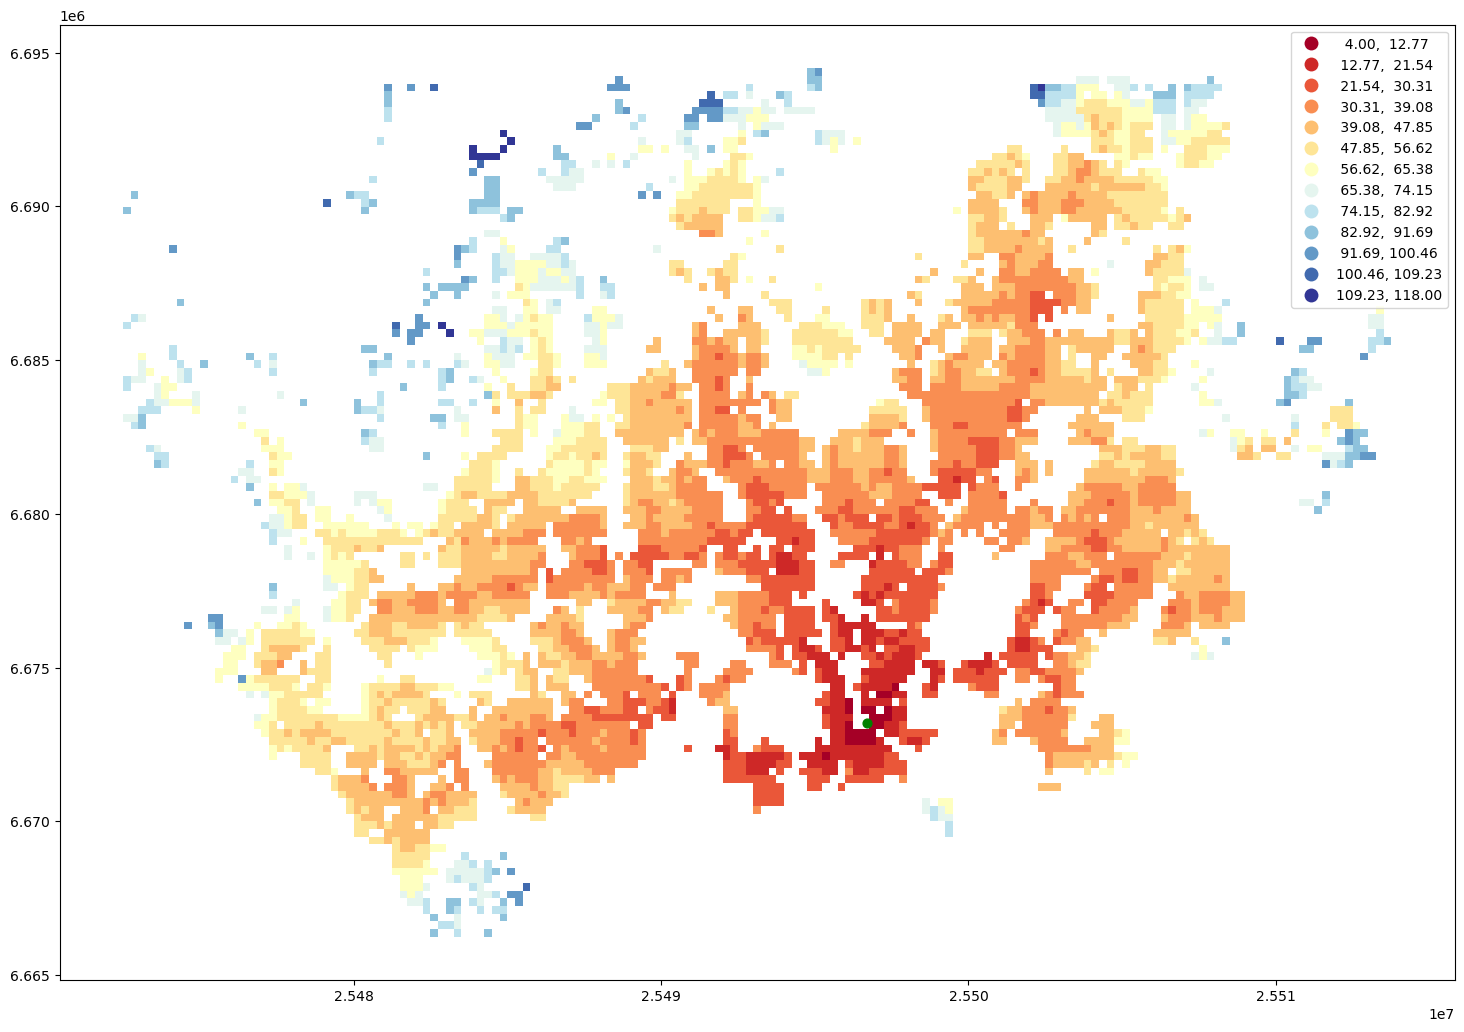

In [31]:
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)

## Calculate travel times by bike

In a very similar manner, we can calculate travel times by cycling. We only need to modify our `TravelTimeMatrix` object a little bit. We specify the cycling speed by using the parameter `speed_cycling` and we change the `transport_modes` parameter to correspond to `[TransportMode.WALK, TransportMode.BICYCLE]`. This will initialize the object for cycling analyses:

In [32]:
ttm_bike = TravelTimeMatrix(
    transport_network,
    origins=station,
    destinations=points,
    speed_cycling=16,
    transport_modes=[TransportMode.WALK, TransportMode.BICYCLE],
)

- Let's again make a table join with the population grid and plot the data:

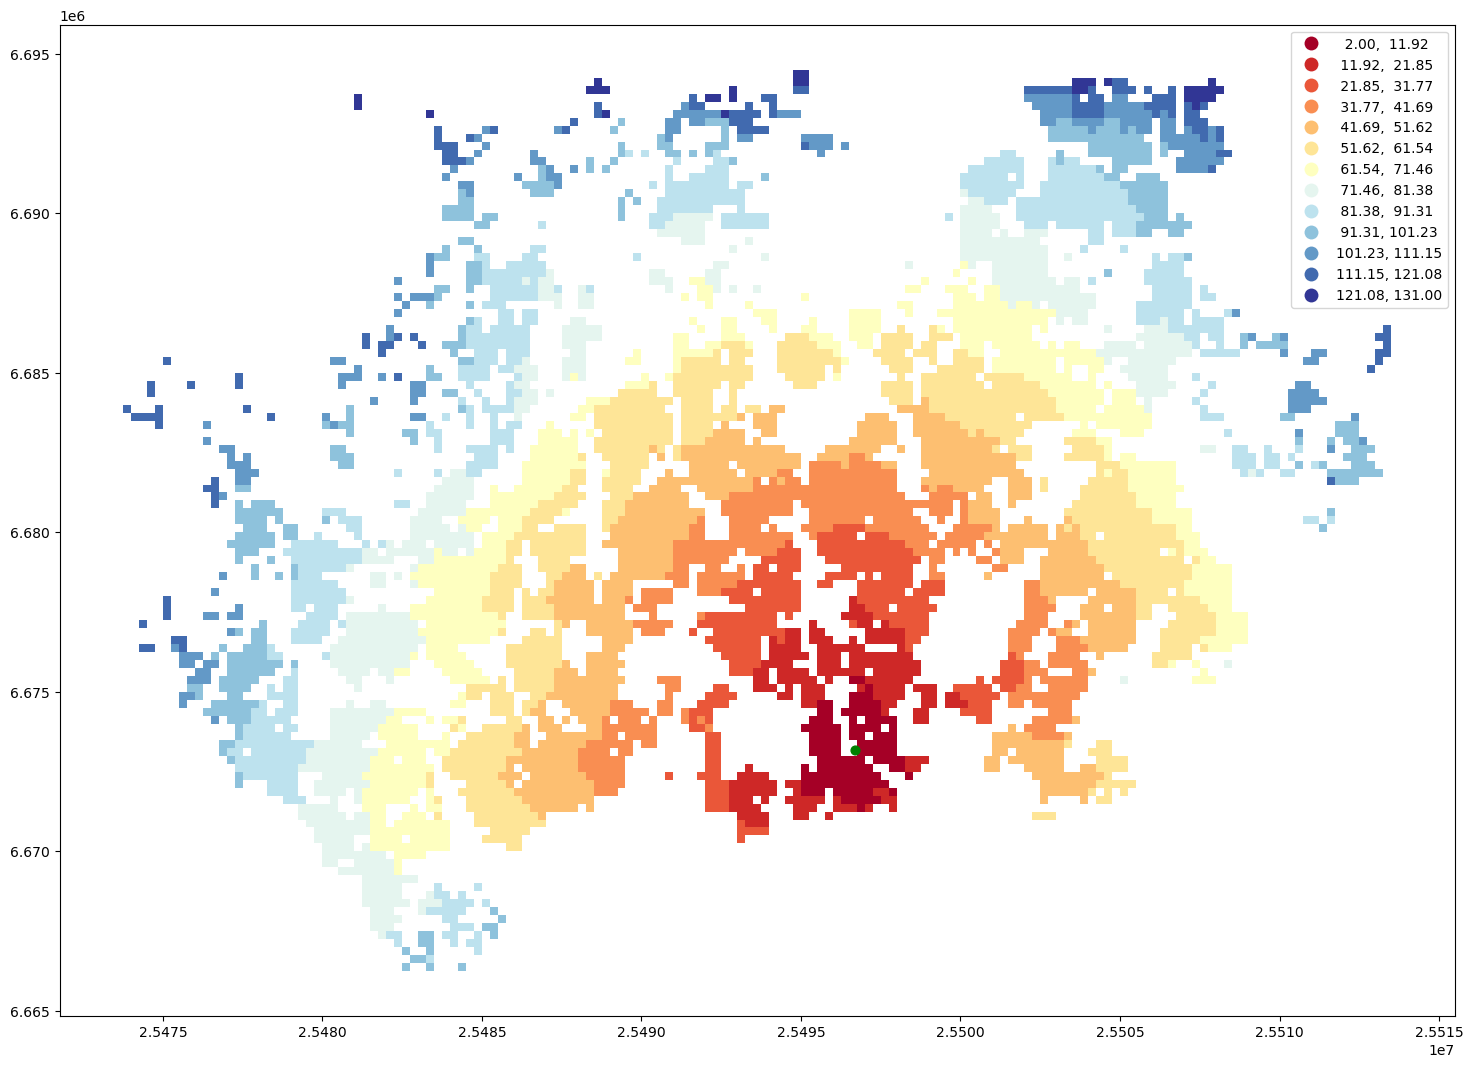

In [33]:
geo = pop_grid.merge(ttm_bike, left_on="id", right_on="to_id")
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="equal_interval", k=13, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)

## Calculate catchment areas

One quite typical accessibility analysis is to find out catchment areas for multiple locations, such as libraries. In the below, we will extract all libraries in Helsinki region and calculate travel times from all grid cells to the closest one. As a result, we have catchment areas for each library.

- Let's start by parsing the libraries in Helsinki region (covering four cities in the region), using `osmnx`:

In [34]:
import osmnx as ox

# Fetch libraries from multiple cities simultaneously
query = ["Helsinki, Finland", "Espoo, Finland", "Vantaa, Finland", "Kauniainen, Finland"]
libraries = ox.features_from_place(query, tags={"amenity": ["library"]})

# Show first rows
libraries.head()

geometry addr:city addr:housenumber  \
element id                                                                
node    50807898   POINT (25.03353 60.19508)  Helsinki                2   
        50821497   POINT (25.05281 60.19452)  Helsinki                2   
        54043622   POINT (25.01303 60.22753)       NaN              NaN   
        60123861   POINT (25.08516 60.23772)  Helsinki                4   
        167268631  POINT (24.87591 60.23879)  Helsinki                5   

                  addr:postcode          addr:street  amenity internet_access  \
element id                                                                      
node    50807898          00880  Linnanrakentajantie  library             yes   
        50821497          00820       Roihuvuorentie  library             NaN   
        54043622            NaN                  NaN  library             NaN   
        60123861          00940             Ostostie  library             NaN   
        167268631         00420         Klaneettitie  library             NaN   

                  level                   name                name:fi  ...  \
element id                                                             ...   
node    50807898      1  Herttoniemen kirjasto  Herttoniemen kirjasto  ...   
        50821497    NaN   Roihuvuoren kirjasto   Roihuvuoren kirjasto  ...   
        54043622    NaN        Viikin kirjasto        Viikin kirjasto  ...   
        60123861    NaN      Kontulan kirjasto      Kontulan kirjasto  ...   
        167268631   NaN    Kannelmäen kirjasto    Kannelmäen kirjasto  ...   

                  source:architect source:start_date air_conditioning name:da  \
element id                                                                      
node    50807898               NaN               NaN              NaN     NaN   
        50821497               NaN               NaN              NaN     NaN   
        54043622               NaN               NaN              NaN     NaN   
        60123861               NaN               NaN              NaN     NaN   
        167268631              NaN               NaN              NaN     NaN   

                  building:part alt_name:ru name:fr name:ja short_name indoor  
element id                                                                     
node    50807898            NaN         NaN     NaN     NaN        NaN    NaN  
        50821497            NaN         NaN     NaN     NaN        NaN    NaN  
        54043622            NaN         NaN     NaN     NaN        NaN    NaN  
        60123861            NaN         NaN     NaN     NaN        NaN    NaN  
        167268631           NaN         NaN     NaN     NaN        NaN    NaN  

[5 rows x 89 columns]

- Some of the libraries might be in Polygon format, so we need to convert them into points by calculating their centroid:

In [35]:
# Convert the geometries to points
libraries["geometry"] = libraries.centroid

/var/folders/f7/rhmqxfmx40s4yv9bhh7skq4m0000gp/T/ipykernel_3166/4134701274.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  libraries["geometry"] = libraries.centroid


- Let's see how the distribution of libraries looks on a map:

In [36]:
libraries.explore(color="red", marker_kwds=dict(radius=5))

In [37]:
# Ensure that every row have an unique id
libraries = libraries.reset_index()
libraries["id"] = libraries.index
libraries.head()

element  id                   geometry addr:city addr:housenumber  \
0    node   0  POINT (25.03353 60.19508)  Helsinki                2   
1    node   1  POINT (25.05281 60.19452)  Helsinki                2   
2    node   2  POINT (25.01303 60.22753)       NaN              NaN   
3    node   3  POINT (25.08516 60.23772)  Helsinki                4   
4    node   4  POINT (24.87591 60.23879)  Helsinki                5   

  addr:postcode          addr:street  amenity internet_access level  ...  \
0         00880  Linnanrakentajantie  library             yes     1  ...   
1         00820       Roihuvuorentie  library             NaN   NaN  ...   
2           NaN                  NaN  library             NaN   NaN  ...   
3         00940             Ostostie  library             NaN   NaN  ...   
4         00420         Klaneettitie  library             NaN   NaN  ...   

  source:architect source:start_date air_conditioning name:da building:part  \
0              NaN               NaN              NaN     NaN           NaN   
1              NaN               NaN              NaN     NaN           NaN   
2              NaN               NaN              NaN     NaN           NaN   
3              NaN               NaN              NaN     NaN           NaN   
4              NaN               NaN              NaN     NaN           NaN   

  alt_name:ru name:fr name:ja short_name indoor  
0         NaN     NaN     NaN        NaN    NaN  
1         NaN     NaN     NaN        NaN    NaN  
2         NaN     NaN     NaN        NaN    NaN  
3         NaN     NaN     NaN        NaN    NaN  
4         NaN     NaN     NaN        NaN    NaN  

[5 rows x 91 columns]

- Next, we can initialize our travel time matrix calculator using the libraries as the origins:

In [38]:
travel_time_matrix = TravelTimeMatrix(
    transport_network,
    origins=libraries,
    destinations=points,
    departure=datetime.datetime(2022,8,15,8,30),
    transport_modes=[TransportMode.TRANSIT, TransportMode.WALK],
)

In [39]:
travel_time_matrix.shape

(561888, 3)

- As we can see, there are almost 540 thousand rows of data, which comes as a result of all connections between origins and destinations. Next, we want aggregate the data and keep only travel time information to the closest library: 

In [40]:
# Find out the travel time to closest library
closest_library = travel_time_matrix.groupby("to_id")["travel_time"].min().reset_index()
closest_library

to_id  travel_time
0        Vaestotietoruudukko_2021.1         57.0
1       Vaestotietoruudukko_2021.10         53.0
2      Vaestotietoruudukko_2021.100         50.0
3     Vaestotietoruudukko_2021.1000         28.0
4     Vaestotietoruudukko_2021.1001         32.0
...                             ...          ...
5848   Vaestotietoruudukko_2021.995         20.0
5849   Vaestotietoruudukko_2021.996         17.0
5850   Vaestotietoruudukko_2021.997         20.0
5851   Vaestotietoruudukko_2021.998         38.0
5852   Vaestotietoruudukko_2021.999         33.0

[5853 rows x 2 columns]

Then we can make a table join with the grid in a similar manner as previously and visualize the data:

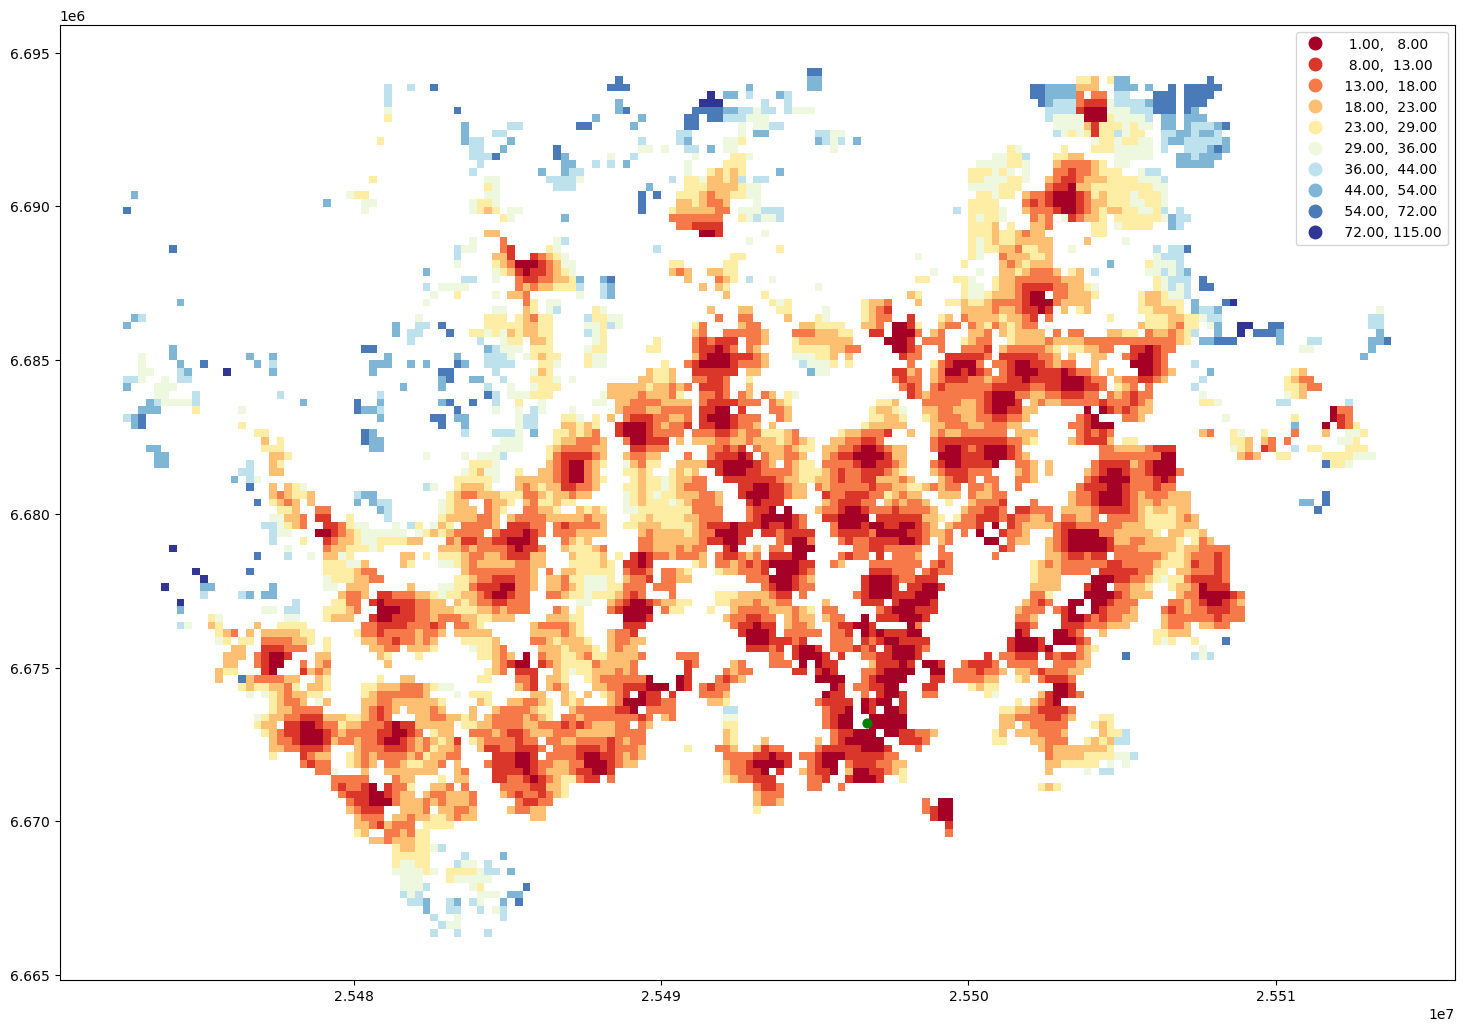

In [41]:
# Make a table join
geo = pop_grid.merge(closest_library, left_on="id", right_on="to_id")

# Visualize the data
ax = geo.plot(column="travel_time", cmap="RdYlBu", scheme="natural_breaks", k=10, legend=True, figsize=(18,18))
ax = station.to_crs(crs=geo.crs).plot(ax=ax, color="green", markersize=40)


That's it! As you can, see now we have a nice map showing the catchment areas for each library.

## Analyze accessibility 

After we have calculated the travel times to the closest services, we can start analyzing accessibility. There are various ways to analyze how accessible services are. Here, for the sake of simplicity, we calculate the number of inhabitants that can reach the services within given travel time thershold (e.g. 15 minutes) by PT (or walking).  

In [42]:
# Extract the grid cells within given travel time threshold
threshold = 15
access = geo.loc[geo["travel_time"]<=threshold].copy()

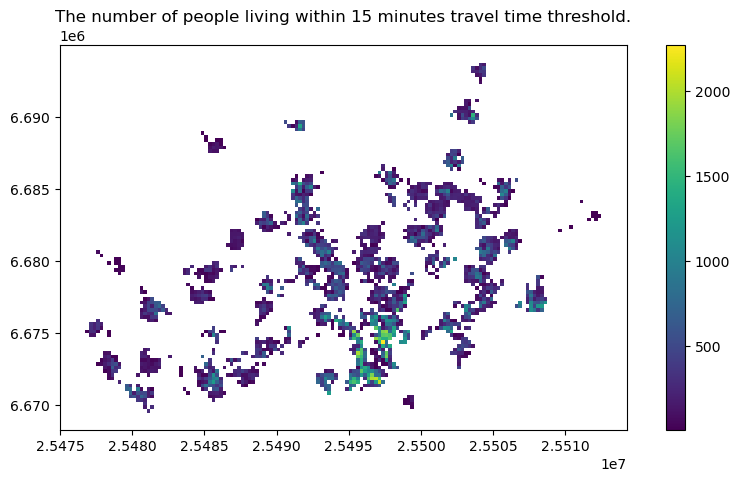

In [43]:
ax = access.plot(column="asukkaita", figsize=(10,5), legend=True)
ax.set_title(f"The number of people living within {threshold} minutes travel time threshold.");

Now we can easily calculate how many people or what is the proportion of people that can access the given service within the given travel time threshold:  

In [44]:
pop_within_threshold = access["asukkaita"].sum()
pop_share = pop_within_threshold / geo["asukkaita"].sum()
print(f"Population within accessibility thresholds: {pop_within_threshold} ({pop_share*100:.0f} %)")

Population within accessibility thresholds: 649517 (54 %)


We can see that approximately 55 % of the population in the region can access a library within given time threshold.
With this information we can start evaluating whether the level of access for the population in the region can be considered as "sufficient" or equitable. Naturally, with more detailed data, we could start evaluating whether e.g. certain population groups have lower access than on average in the region, which enables us to start studying the questions of justice and equity. Often the interesting question is to understand "who does not have access"? I.e. who is left out. 

There are many important questions relating to equity of access that require careful consideration when doing these kind of analyses is for example what is seen as "reasonable" level of access. I.e. what should be specify as the travel time threshold in our analysis. Answering to these kind of questions is not straightforward as the accessibility thresholds (i.e. travel time budget) are very context dependent and normative (value based) by nature. 

## Cumulative opportunities 

Another commonly used approach to analyze accessibility is to analyze how many services can a given individual (or group of individuals) access within given travel time budget. This is called cumulative opportunities measure.

In [45]:
# How many services can be reached from each grid cell within given travel time threshold?
travel_time_matrix.head()

from_id                       to_id  travel_time
0        0  Vaestotietoruudukko_2021.1        117.0
1        0  Vaestotietoruudukko_2021.2        110.0
2        0  Vaestotietoruudukko_2021.3        104.0
3        0  Vaestotietoruudukko_2021.4        106.0
4        0  Vaestotietoruudukko_2021.5        100.0

In [46]:
threshold = 15
# Count the number of opportunities from each grid cell
opportunities = travel_time_matrix.loc[travel_time_matrix["travel_time"]<=threshold].groupby("to_id")["from_id"].count().reset_index()

# Rename the column for more intuitive one
opportunities = opportunities.rename(columns={"from_id": "num_opportunities"})
opportunities.head()

to_id  num_opportunities
0  Vaestotietoruudukko_2021.1022                  1
1  Vaestotietoruudukko_2021.1023                  1
2  Vaestotietoruudukko_2021.1026                  1
3  Vaestotietoruudukko_2021.1044                  1
4  Vaestotietoruudukko_2021.1069                  1

In [47]:
# Merge with population grid
opportunities = pop_grid.merge(opportunities, left_on="id", right_on="to_id")

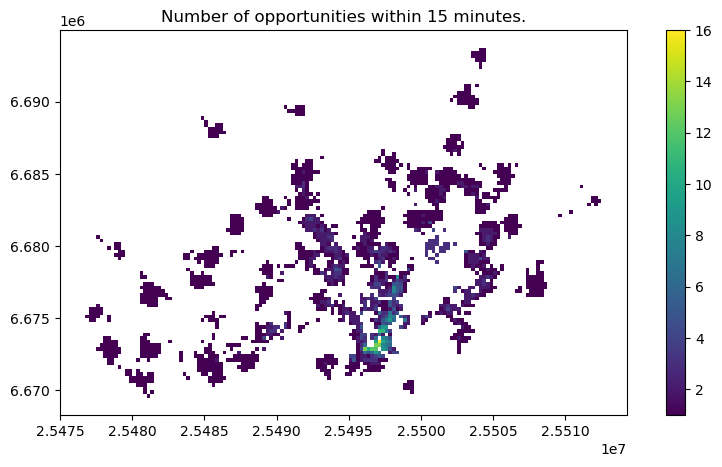

In [48]:
# Plot the results
ax = opportunities.plot(column="num_opportunities", figsize=(10,5), legend=True)
ax.set_title(f"Number of opportunities within {threshold} minutes."); 

Now we can clearly see the areas with highest level of accessibility to given service. This is called cumulative opportunities measure or "Hansen's Accessibility" measure after its developer.  

At times one could still want apply a distance decay function to give more weight to the closer services and less to the services that are further away, and hence less likely to be visited by citizens who seek to use the service. This is called as time-weighted cumulative opportunities measure. There are also many other approaches to measure accessibility which are out of scope of this tutorial. In case you are interested in understanding more, I recommend reading following papers:

- Levinson, D. & H. Wu (2020). [Towards a general theory of access.](https://www.jtlu.org/index.php/jtlu/article/view/1660)
- Wu, H. & D. Levinson (2020). [Unifying access.](https://www.sciencedirect.com/science/article/abs/pii/S1361920920305423)

## Where to go next?

In case you want to learn more, we recommend reading:
- [r5py documentation](https://r5py.readthedocs.io/latest) that provides much more details on how to use `r5py`.